# Aula 15 - Introdução a Redes Neurais

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Exercício Aula anterior
- 2) CNN
- 3) RNN

Até agora, nós vimos diversos tipos de redes neurais, e elas podem ser utilizadas para diversos problemas. A partir de entradas, elas calculavam uma saída como previsão. 

Porém, um tipo de dados comuns de se trabalhar são os __sequenciais__, como séries temporais e textos.

<div>
<img src="https://www.tradingview.com/x/BIMmjLxL/" width=600 align="center"/>
</div>

<div>
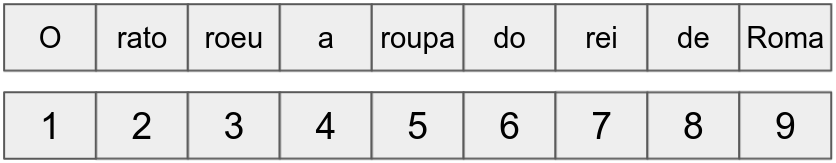
</div>

Nesse tipo de dados, os valores "passados" tem forte relação com os valores "futuros", algo que não está explícito nas arquiteturas que vimos até aqui. Para tentar explicitar isso, vamos usar __redes neurais recorrentes__.

# Redes Neurais Recorrentes

Nas __redes neurais recorrentes__, a saída de uma camada escondida também funciona como a entrada dessa mesma camada escondida! 

Mas como funciona isso? Imagina que a saída em um dado passo de tempo é a entrada no passo de tempo seguinte.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg" align="center"/>
</div>
ref: https://commons.wikimedia.org/wiki/User:Ixnay


Assim, de certa forma, a nossa camada escondida vai funcionar como uma __memória__ da rede neural.

Fora isso, nossas equações vão ser as mesmas que antes, com $ V $ sendo o mesmo peso para todos os passos de tempo. Algumas mudanças mais técnicas vão ocorrer nas equações para atualização dos pesos, mas não precisamos entrar nesse nível de detalhe.

$$ \mathbf{h}(t) = g_h (\mathbf{V} \cdot \mathbf{h}(t-1) + \mathbf{U} \cdot \mathbf{x}(t) + \mathbf{b}_h) $$

$$ \mathbf{o}(t) = g_o (\mathbf{W} \cdot\mathbf{h}(t) + \mathbf{b}_o) $$

Vamos ver um exemplo simples de como essa rede funcionaria. Imagina que tenho sequências das letras A e B, como "AAABBBAA", ou "AAAAAAA", etc....

Queremos que o estado interno da minha rede neural seja a contagem do número de vezes que cada letra aparecer na sequência.

Lembrando que redes neurais são funções de ativação com produtos matriciais:

<div>
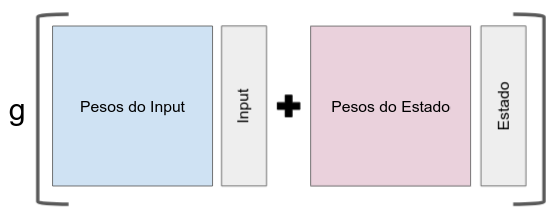
</div>

Quais teriam que ser os pesos da minha rede neural?

A função de ativação vai ser linear ("identidade")

<div>
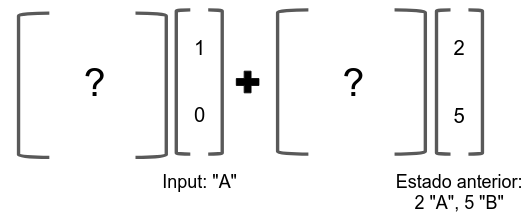
</div>

In [ ]:
import itertools
import math
import time

import torch
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

# Olhando debaixo do capô

In [ ]:
class RNN:
    def __init__(self, weight_state, weight_input, state0):
        self.W_ss = weight_state
        self.W_sx = weight_input
        self.state = state0
        
    def update(self, data):
        self.state = self.W_sx @ data + self.W_ss @ self.state

In [ ]:
def word_to_vec(word):
    vocab = np.array(['A','B'])
    return list(np.where(vocab==word, 1, 0))

def index_to_word(idx):
    vocab = np.array(['A','B'])
    return vocab[idx]

In [ ]:
data_1 = 'AAAAAAAA'
data_2 = 'AABBBBBB'
data_3 = 'BAABBABA'

In [ ]:
sent_1 = [word_to_vec(w) for w in data_1]
sent_2 = [word_to_vec(w) for w in data_2]
sent_3 = [word_to_vec(w) for w in data_3]

In [ ]:
print(sent_1)

In [ ]:
s0 = np.array([0.0,0.0])
W_ss = np.array([[1.0, 0.0], [0.0, 1.0]])
W_sx = np.array([[1.0, 0.0], [0.0, 1.0]])

model = RNN(W_ss, W_sx, s0)

In [ ]:
print(sent_1)
print(model.state)

In [ ]:
model.update(sent_1[0])
print(model.state)

In [ ]:
model.update(sent_1[1])
print(model.state)

In [ ]:
model.update(sent_1[2])
print(model.state)

In [ ]:
print(data_2)

In [ ]:
model = RNN(W_ss, W_sx, s0)

for ch in sent_2:
    model.update(ch)
    print(model.state)

In [ ]:
# Inicializamos nossa RNN para ficar igual ao nosso exemplo simplificado
weight_state_init = tf.constant_initializer(W_ss)
weight_input_init = tf.constant_initializer(W_sx)


# Vamos entender cada parâmetro
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(
                              units=2, # Número de neurônios de saída
                              input_shape=[8,2], # Shape dos dados de entrada, "None" significa "variável"
                              activation=None, # Função de ativação, "None" significa "linear", ou "f(x)=x"
                              use_bias=False, # Usar ou não usar um vetor de bias
                              recurrent_initializer=weight_state_init, # Peso dos estados passados
                              kernel_initializer=weight_input_init, # Peso das entradas (inputs)
                              return_sequences=False # Retornar ou não a sequência de saídas
                             ) 
])

# Neste caso, como não estamos dando uma função de ativação, nem uma camada de saída,
# este modelo vai nos dar apenas os estados que estamos calculando.

# Como vimos antes, com essas matrizes de pesos, nós só contamos quantas vezes cada letra aparece.

In [ ]:
model.compile()

In [ ]:
# Vamos calcular as contagens de todas as sentenças ao mesmo tempo.
print(model.predict(np.array([sent_1, sent_2, sent_3])))

In [ ]:
print(data_1)
print(data_2)
print(data_3)

# Prevendo Séries Temporais

In [ ]:
# https://gml.noaa.gov/ccgg/trends/mlo.html

df = pd.read_csv('./datasets/MaunaLoa_CO2.csv', sep=',', decimal='.', index_col=False)

In [ ]:
df.head()

In [ ]:
df.describe().transpose()

In [ ]:
df[:100].plot.line(y='average')

In [ ]:
series = df['average'].values

In [ ]:
series.shape

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

train_series, _ = train_test_split(series.reshape(-1,1), test_size = 339, shuffle=False)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_series)

scaled_series = scaler.transform(series.reshape(-1,1))

In [ ]:
# Vamos dar uma olhada no Timeseries Generator
window_size = 5
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(data=scaled_series, 
                                                                targets=scaled_series, 
                                                                length=window_size,
                                                                batch_size=1,
                                                                start_index=0,
                                                                end_index=427)

In [ ]:
generator[0]

In [ ]:
scaled_series[:6]

In [ ]:
window_size = 12

series_train = tf.keras.preprocessing.sequence.TimeseriesGenerator(data=scaled_series, 
                                                                targets=scaled_series, 
                                                                length=window_size,
                                                                batch_size=1,
                                                                start_index=0,
                                                                end_index=427)

series_val = tf.keras.preprocessing.sequence.TimeseriesGenerator(data=scaled_series, 
                                                                targets=scaled_series, 
                                                                length=window_size,
                                                                batch_size=1,
                                                                start_index=428,
                                                                end_index=611)

series_test = tf.keras.preprocessing.sequence.TimeseriesGenerator(data=scaled_series, 
                                                                targets=scaled_series, 
                                                                length=window_size,
                                                                batch_size=1,
                                                                start_index=612,
                                                                end_index=765)

In [ ]:
X_train,y_train = np.array([row[0][0] for row in series_train]), np.array([row[1][0] for row in series_train])

X_val,y_val = np.array([row[0][0] for row in series_val]), np.array([row[1][0] for row in series_val])

X_test,y_test = np.array([row[0][0] for row in series_test]), np.array([row[1][0] for row in series_test])

In [ ]:
print(X_train.shape)
print(y_train.shape)

In [ ]:
print(X_val.shape)
print(y_val.shape)

In [ ]:
print(X_test.shape)
print(y_test.shape)

## Rodando com RNN simples

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.001,
                           patience = 5, 
                           verbose = 1, mode = 'auto')

In [ ]:
rnn_co2 = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [ ]:
rnn_co2.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
rnn_co2.summary()

In [ ]:
historico = rnn_co2.fit(series_train, 
                        validation_data=series_val,
                        epochs=20)

In [ ]:
rnn_co2.evaluate(series_val)

In [ ]:
y_pred = np.concatenate([rnn_co2.predict(X_train), rnn_co2.predict(X_val)])

In [ ]:
plt.plot(np.concatenate([y_train, y_val]))
plt.plot(y_pred, '--', color='Orange')

## Rodando com RNN de mais camadas

In [ ]:
rnn_co2_2 = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(20),
    tf.keras.layers.Dense(1)
])

In [ ]:
rnn_co2_2.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
rnn_co2_2.summary()

In [ ]:
historico = rnn_co2_2.fit(series_train, 
                          validation_data=series_val,
                          epochs=20)

In [ ]:
rnn_co2_2.evaluate(series_val)

In [ ]:
y_pred = np.concatenate([rnn_co2_2.predict(X_train), rnn_co2_2.predict(X_val)])

In [ ]:
plt.plot(np.concatenate([y_train, y_val]))
plt.plot(y_pred, '--', color='Orange')

# LSTM

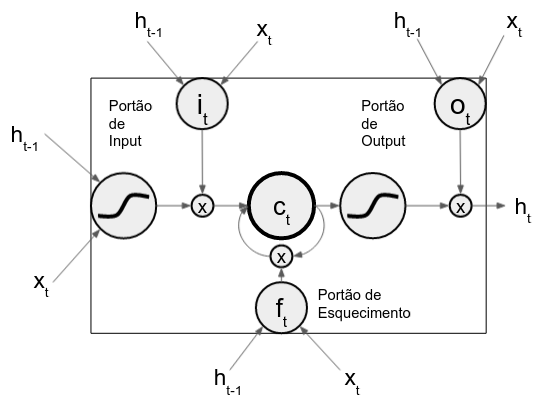

<div>
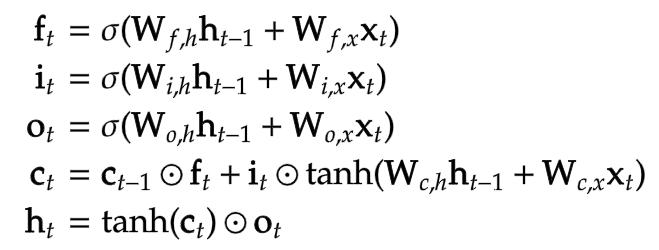
</div>

In [ ]:
lstm_co2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[None,1]),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dense(1)
])

In [ ]:
lstm_co2.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
lstm_co2.summary()

In [ ]:
historico = lstm_co2.fit(series_train, 
                          validation_data=series_val,
                          epochs=20)

In [ ]:
lstm_co2.evaluate(series_val)

In [ ]:
y_pred = np.concatenate([lstm_co2.predict(X_train), lstm_co2.predict(X_val)])

In [ ]:
plt.plot(np.concatenate([y_train, y_val]))
plt.plot(y_pred, '--', color='Orange')

# Comparando todos na base de teste

## 1) RNN Simples

In [ ]:
y_pred = np.concatenate([rnn_co2.predict(X_train), rnn_co2.predict(X_val), rnn_co2.predict(X_test)])

In [ ]:
plt.plot(np.concatenate([y_train, y_val, y_test]))
plt.plot(y_pred, '--', color='Orange')

## 2) RNN Multicamadas

In [ ]:
y_pred = np.concatenate([rnn_co2_2.predict(X_train), rnn_co2_2.predict(X_val), rnn_co2_2.predict(X_test)])

In [ ]:
plt.plot(np.concatenate([y_train, y_val, y_test]))
plt.plot(y_pred, '--', color='Orange')

## 3) LSTM

In [ ]:
y_pred = np.concatenate([lstm_co2.predict(X_train), lstm_co2.predict(X_val), lstm_co2.predict(X_test)])

In [ ]:
plt.plot(np.concatenate([y_train, y_val, y_test]))
plt.plot(y_pred, '--', color='Orange')